In [1]:
# If you get a "ModuleNotFound" error for m2cgen, run this cell
!pip install m2cgen

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import m2cgen as m2c
import matplotlib.pyplot as plt

# Create your own model

## Step 1: import the data

The after providing a list of filenames to the `files` variable, the cell below looks in the data folder for those files.
The output of this cell is a dataframe `d` where each row is one of your measurements. The columns show the different types of measurements (*e.g.* minimum x acceleration, minimum y acceleration) as well as the type of motion that it was. You can also look at `data/all_data.csv` if you want to see this information in a spreadsheet.

In [3]:
#######################
##### Change this #####
files = ['no_move.csv',
         'circle.csv',
         'z.csv',
         'w.csv',
         'flick.csv'
        ]
######################

# Initialize an empty list to hold each file
dfs = []
# Go through each file
for i,file in enumerate(files):
    # Read the data into Pandas
    df = pd.read_csv('data/'+file)
    df = df.drop('Time (seconds)', axis=1)
    df['label'] = i
    dfs.append(df)
d = pd.concat(dfs, ignore_index=True)
d.to_csv('data/all_data.csv', index=False)
d

,min_x,min_y,min_z,max_x,max_y,max_z,peaks_x,peaks_y,peaks_z,mean_x,mean_y,mean_z,std_x,std_y,std_z,label
0,-36,128,-1076,-20,144,-1040,0,0,0,-26.68,134.64,-1059.2000,4.002204,4.426042,6.480741,0
1,-20,140,-1076,-4,160,-1040,0,0,0,-13.32,149.80,-1057.7600,4.527428,4.711605,7.721723,0
2,440,136,-848,640,244,-708,0,0,0,590.96,167.48,-782.9200,36.108780,17.983660,21.718370,0
3,448,-692,-628,552,-640,-508,0,0,0,508.84,-661.84,-550.6400,19.451060,10.076270,21.151980,0
4,-448,-760,560,-348,-712,732,0,0,0,-389.16,-739.28,652.6800,20.017960,11.160760,33.509790,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,-1688,-1712,-2040,120,828,2040,0,3,2,-239.92,139.96,-825.2000,273.815700,540.886200,929.459600,4
121,-1372,-2040,-2040,420,724,2040,4,3,3,-197.36,116.72,-950.2399,283.018200,401.215100,801.512100,4
122,-1648,-1492,-2040,872,696,2016,1,3,3,-143.24,91.44,-809.0400,280.124400,410.947000,966.240500,4
123,-1212,-1564,-2040,572,772,2040,4,7,2,-144.56,69.76,-858.9600,255.126000,491.423200,944.439600,4


In order to evaluate how well our model will perform in the "real world" we need to have testing data that the model has never seen before.
The easiset way to do this is to separate all of our measurements into a "training" portion and a "testing" portion.
That is what the `train_test_split()` function does in the cell below.

In [4]:
# separate my data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(d.drop('label', axis=1).values, d['label'].values, test_size=0.2)
# Print the results
print(f"The training set has {X_train.shape[0]} rows. Here is the first one:")
print(X_train[0,:])
print(f"\nThe testing set has {X_test.shape[0]} rows. Here is the first one:")
print(X_test[0,:])

The training set has 100 rows. Here is the first one:
[-1.648000e+03 -1.492000e+03 -2.040000e+03  8.720000e+02  6.960000e+02
  2.016000e+03  1.000000e+00  3.000000e+00  3.000000e+00 -1.432400e+02
  9.144000e+01 -8.090400e+02  2.801244e+02  4.109470e+02  9.662405e+02]

The testing set has 25 rows. Here is the first one:
[ 656.      -284.      -720.       768.      -176.      -560.
    0.         0.         0.       691.9199  -223.44    -665.12
   23.08341   21.67408   33.97931]


## Step 2: Train your model

For this machine learning model, we will use a decision tree classifier.
A decision tree classifier works somewhat like the game 20 questions: the computer asks yes or no questions about the data.
Based on the response, the computer will ask different questions until it's reasonably sure of the answer.
These different Yes/No chains kind of look look like a tree, hence the name decision tree classifier.

Since the only information the model has access to are the 15 data points for each run, the yes/no questions are all in the form of inequalities (*e.g* Is the max acceleration in the z direction >= 1688?).

In [5]:
# Tell the computer we want a decision tree classifier
dtc = DecisionTreeClassifier()
# Use the training data to train the model
dtc = dtc.fit(X_train, y_train)
# See how accurate the model is using the testing data
dtc_acc = dtc.score(X_test, y_test)
# Print the result
print(f"The accuracy of the model is {dtc_acc:.2%}")

The accuracy of the model is 100.00%


We can visualize the decision tree classifier as a series of boxes that each ask a single question.
If the answer is yes, follow the arrow that goes down and to the left.
If the answer is no, follow the arrow that goes down and to the right.
Keep going until there are no more arrows to follow, then look at the "class" to determine the gesture type!

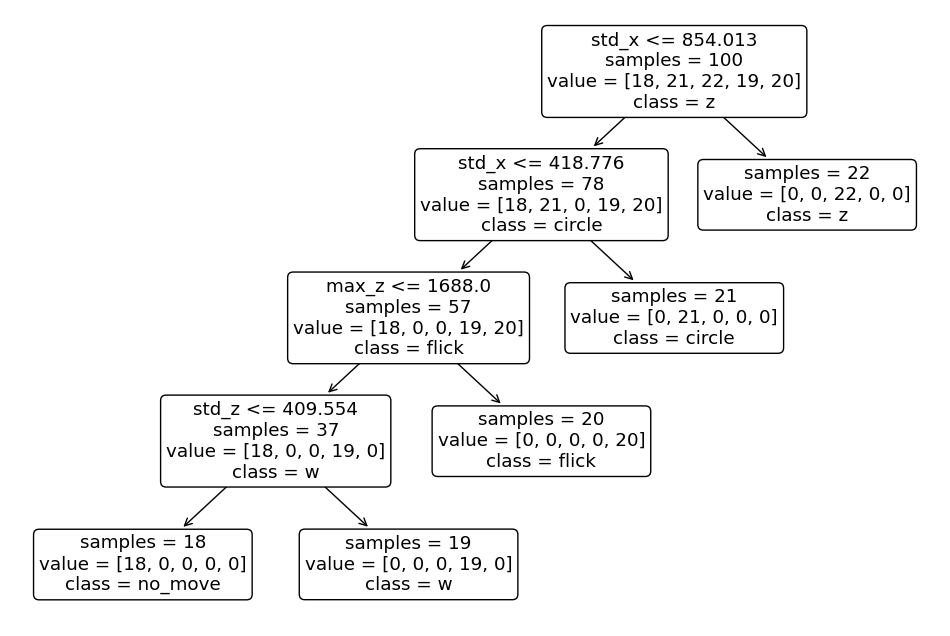

In [6]:
# Make a figure
plt.figure(figsize=(12,8))
# Display the decision tree
plot_tree(dtc, feature_names=df.columns.values[:-1],
          class_names=[x[:-4] for x in files], impurity=False, rounded=True)
# Show the figure
plt.show()

## Step 3: export the model

Here, we export the decision tree classifier as pure python code.

In [7]:
# convert model to pure python code
code = m2c.export_to_python(dtc)
# save converted model as .py file
with open('model.py', 'w') as f:
    f.write(code)
# Print the code
print(code)

def score(input):
    if input[12] <= 854.0129699707031:
        if input[12] <= 418.7758026123047:
            if input[5] <= 1688.0:
                if input[14] <= 409.5538959503174:
                    var0 = [1.0, 0.0, 0.0, 0.0, 0.0]
                else:
                    var0 = [0.0, 0.0, 0.0, 1.0, 0.0]
            else:
                var0 = [0.0, 0.0, 0.0, 0.0, 1.0]
        else:
            var0 = [0.0, 1.0, 0.0, 0.0, 0.0]
    else:
        var0 = [0.0, 0.0, 1.0, 0.0, 0.0]
    return var0

